In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

### Data quality asessment and data cleaning

In [33]:
data = pd.read_csv("sp500_stocks.csv", parse_dates=["Date"])

In [41]:
symbols = data["Symbol"].nunique()
symbols

503

In [42]:
print(data.head())

colunas = [col for col in data.columns if col not in ["Symbol", "Date"]]

empresas_validas = data.groupby("Symbol").filter(
    lambda x: not x[colunas].isna().all().all()
)

empresas_validas.to_csv("sp500_filtered.csv", index=False)



        Date Symbol  Adj Close  Close  High  Low  Open  Volume
0 2010-01-04    MMM        NaN    NaN   NaN  NaN   NaN     NaN
1 2010-01-05    MMM        NaN    NaN   NaN  NaN   NaN     NaN
2 2010-01-06    MMM        NaN    NaN   NaN  NaN   NaN     NaN
3 2010-01-07    MMM        NaN    NaN   NaN  NaN   NaN     NaN
4 2010-01-08    MMM        NaN    NaN   NaN  NaN   NaN     NaN


In [43]:
data_filtered = pd.read_csv("sp500_filtered.csv")
quantidade_symbols = data_filtered["Symbol"].nunique()
quantidade_symbols

168

In [44]:
empresas = data_filtered["Symbol"].unique() 
dados_por_empresa = {empresa: data_filtered[data_filtered["Symbol"] == empresa] for empresa in empresas}


In [45]:
empresa_especifica = "ZBRA"  
dados_empresa_especifica = dados_por_empresa.get(empresa_especifica)

print(dados_empresa_especifica.head())

              Date Symbol  Adj Close      Close       High        Low  \
626918  2010-01-04   ZBRA  28.670000  28.670000  28.700001  28.070000   
626919  2010-01-05   ZBRA  28.620001  28.620001  29.370001  28.540001   
626920  2010-01-06   ZBRA  28.400000  28.400000  28.490000  27.320000   
626921  2010-01-07   ZBRA  27.690001  27.690001  28.299999  27.610001   
626922  2010-01-08   ZBRA  27.600000  27.600000  27.610001  27.280001   

             Open    Volume  
626918  28.469999  168800.0  
626919  28.549999  168800.0  
626920  27.410000  385300.0  
626921  28.230000  183600.0  
626922  27.580000  266500.0  


### Data pre-processing

Lagged Features

	•	Previous days values to predict future prices.

In [7]:

for lag in [1, 3, 7]:
    data[f"Close_lag_{lag}"] = data["Close"].shift(lag)

 Moving Averages

	•	Smooth data and trends over a window 

In [8]:
data["MA_5"] = data["Close"].rolling(window=5).mean()
data["MA_10"] = data["Close"].rolling(window=10).mean()

Volatility Indicators

	•	Standard deviation or percentage changes

In [9]:
data["Volatility_5"] = data["Close"].rolling(window=5).std()

Rate of Change (Momentum)

	•	Momentum of price movements

In [10]:
data["ROC_5"] = data["Close"].pct_change(periods=5)

Relative Strength Index (RSI)

	•	Overbought or oversold conditions

In [11]:
def calculate_rsi(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data["RSI"] = calculate_rsi(data)

In [12]:
data["Target"] = data["Close"].shift(-1)

In [13]:
scaler = MinMaxScaler()
numeric_columns = ["Open", "High", "Low", "Close", "Volume", "Close_lag_1", "Close_lag_3", "Close_lag_7" ,"MA_5", "MA_10", "Volatility_5", "ROC_5", "RSI", "Target"]
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [14]:
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

/var/folders/29/yz154g2n03j9k918c59x5_f40000gn/T/ipykernel_30882/545310497.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/29/yz154g2n03j9k918c59x5_f40000gn/T/ipykernel_30882/545310497.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [15]:
data

,Date,Open,High,Low,Close,Volume,Close_lag_1,Close_lag_3,Close_lag_7,MA_5,MA_10,Volatility_5,ROC_5,RSI,Target
0,2010-01-04,0.022808,0.025889,0.027053,0.028271,0.309232,0.028271,0.028518,0.028844,0.028071,0.023602,0.019551,0.542964,0.305440,0.029175
1,2010-01-05,0.026938,0.026597,0.030407,0.029175,0.152825,0.028271,0.028518,0.028844,0.028071,0.023602,0.019551,0.542964,0.305440,0.029334
2,2010-01-06,0.027720,0.027254,0.031505,0.029334,0.411523,0.029175,0.028518,0.028844,0.028071,0.023602,0.019551,0.542964,0.305440,0.030499
3,2010-01-07,0.027864,0.028093,0.030832,0.030499,0.442590,0.029334,0.028518,0.028844,0.028071,0.023602,0.019551,0.542964,0.305440,0.031342
4,2010-01-08,0.028954,0.028845,0.032087,0.031342,0.350741,0.030499,0.029430,0.028844,0.028071,0.023602,0.019551,0.542964,0.305440,0.031854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3538,2024-01-25,0.989936,0.991550,0.987983,0.991353,0.442152,0.984795,0.988705,0.977938,0.990234,0.986374,0.098473,0.575013,0.824684,0.990536
3539,2024-01-26,0.990514,0.993741,0.991089,0.990536,0.341984,0.991353,0.992365,0.970945,0.992877,0.989274,0.087974,0.537939,0.810714,1.000000
3540,2024-01-29,0.991550,0.999543,0.992608,1.000000,0.328153,0.990536,0.993385,0.981846,0.996881,0.993048,0.121717,0.553229,0.790146,0.999242
3541,2024-01-30,1.000000,1.000000,1.000000,0.999242,0.380997,1.000000,1.000000,0.997226,1.000000,0.997212,0.120246,0.543140,0.802429,0.978931


### Exploratory Data Analysis

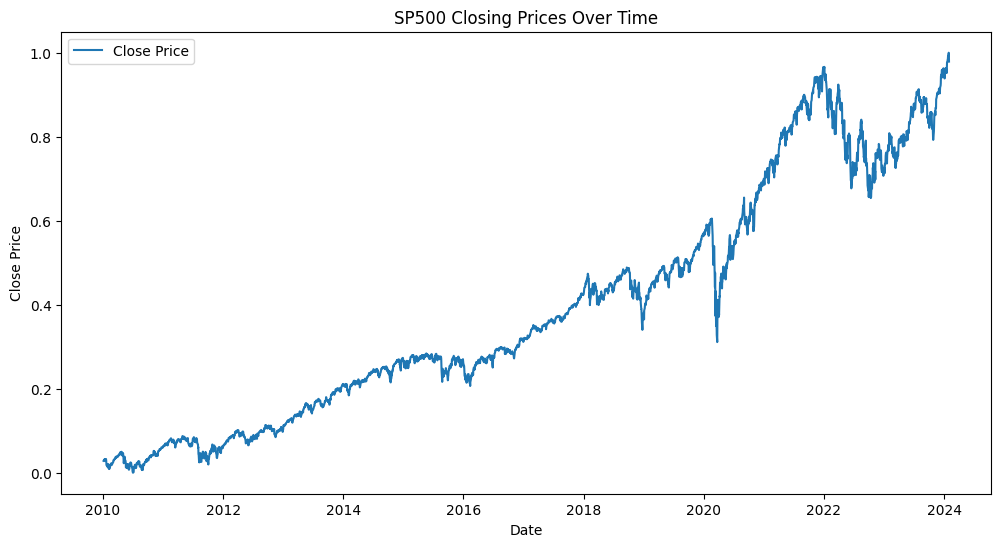

In [16]:

plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.title('SP500 Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

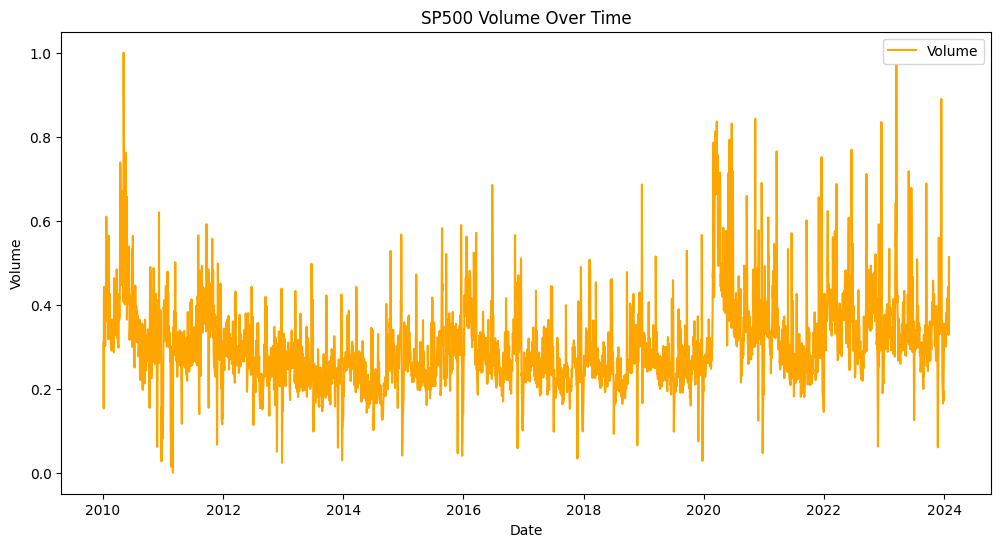

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Volume'], color='orange', label='Volume')
plt.title('SP500 Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

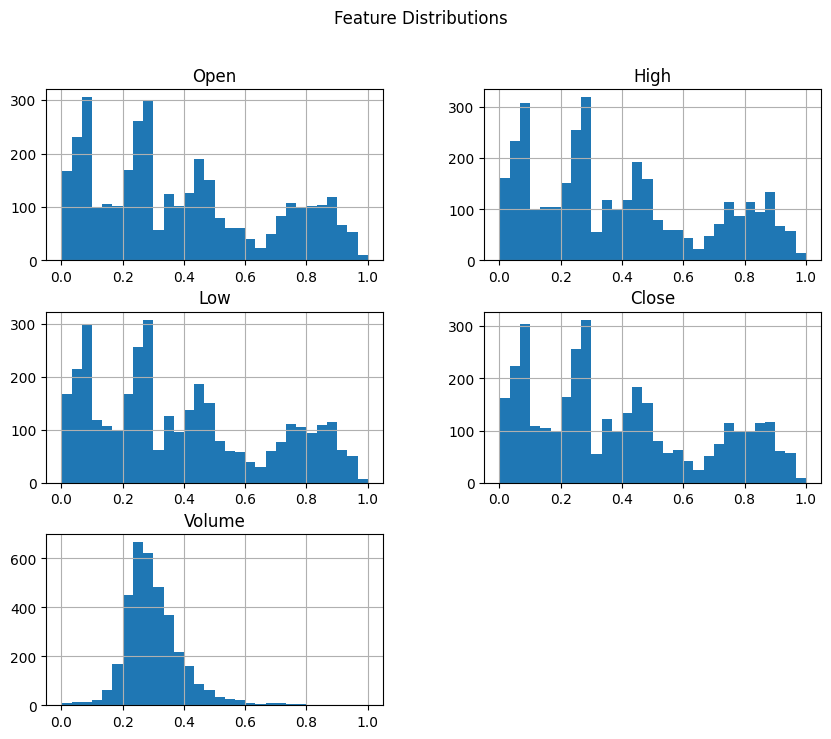

In [18]:
data[['Open', 'High', 'Low', 'Close', 'Volume']].hist(figsize=(10, 8), bins=30)
plt.suptitle('Feature Distributions')
plt.show()

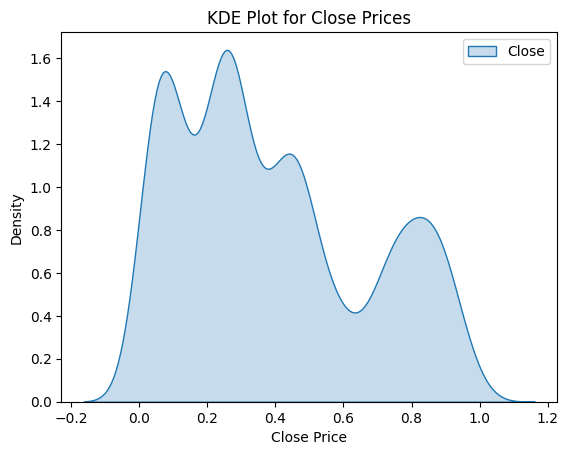

In [19]:
sns.kdeplot(data['Close'], label='Close', fill=True)
plt.title('KDE Plot for Close Prices')
plt.xlabel('Close Price')
plt.legend()
plt.show()

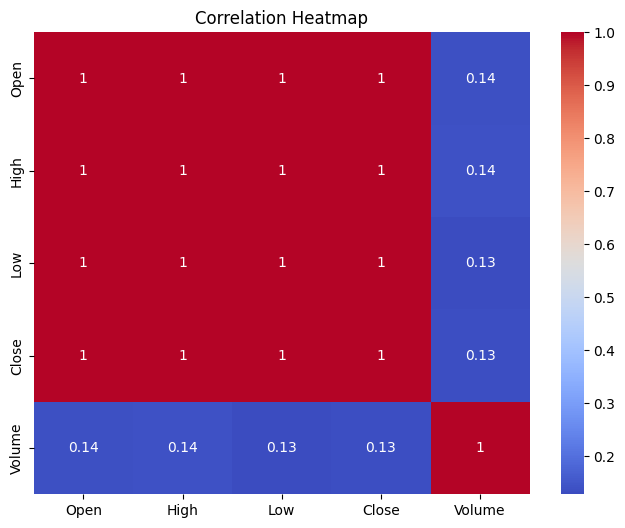

In [20]:
corr_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

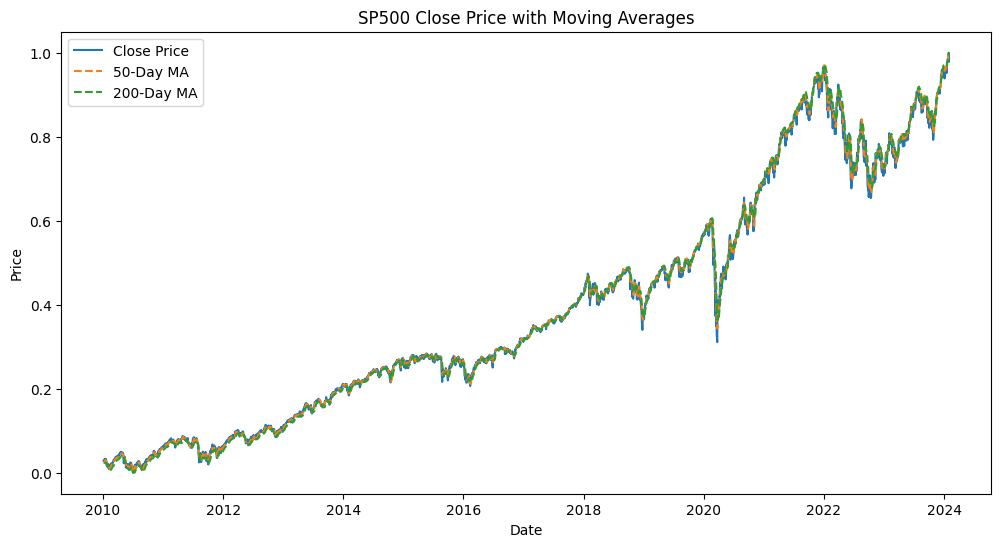

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['MA_5'], label='50-Day MA', linestyle='--')
plt.plot(data['Date'], data['MA_10'], label='200-Day MA', linestyle='--')
plt.title('SP500 Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [22]:
result = adfuller(data['Close'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: 0.3525928899375352
p-value: 0.9796328480637391
Critical Value 1%: -3.432213350242838
Critical Value 5%: -2.8623633225589806
Critical Value 10%: -2.567208268744065


In [23]:
'''decomposition = seasonal_decompose(data['Close'], period=252, model='additive')  # Assuming 252 trading days/year
decomposition.plot()
plt.show()'''

"decomposition = seasonal_decompose(data['Close'], period=252, model='additive')  # Assuming 252 trading days/year\ndecomposition.plot()\nplt.show()"

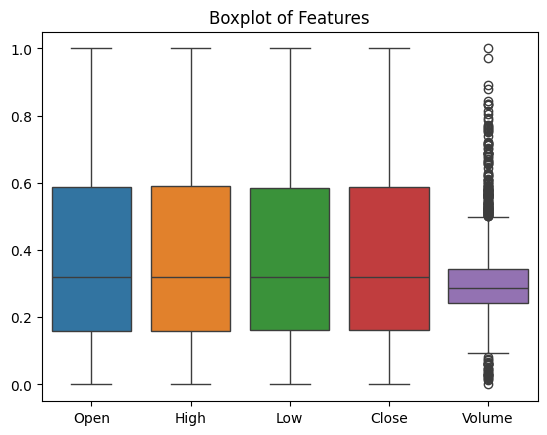

In [31]:
sns.boxplot(data=data[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.title('Boxplot of Features')
plt.show()

In [25]:
'''sns.pairplot(data[['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7']])
plt.show()'''

"sns.pairplot(data[['Close', 'Close_lag_1', 'Close_lag_3', 'Close_lag_7']])\nplt.show()"

In [26]:
train_data = data[(data['Date'] >= '2010-01-01') & (data['Date'] < '2022-07-01')]
val_data = data[(data['Date'] >= '2022-07-01') & (data['Date'] < '2024-01-01')]
test_data = data[data['Date'] >= '2024-01-01']

X_train = train_data.drop(['Date', 'Target'], axis=1)
y_train = train_data['Target']
X_test = test_data.drop(['Date', 'Target'], axis=1)
y_test = test_data['Target']
X_val = val_data.drop(['Date', 'Target'], axis=1)
y_val = val_data['Target']

In [27]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Random Forest - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

Random Forest - RMSE: 0.03, MAE: 0.02, MAPE: 2.50%


In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"XGBoost - RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}, MAPE: {mape_xgb:.2f}%") #mase procurar

XGBoost - RMSE: 0.03, MAE: 0.03, MAPE: 2.77%


In [29]:
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
svr_model.fit(X_train, y_train)

y_pred_svr = svr_model.predict(X_test)

# Evaluate
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mape_svr = np.mean(np.abs((y_test - y_pred_svr) / y_test)) * 100

print(f"SVR - RMSE: {rmse_svr:.2f}, MAE: {mae_svr:.2f}, MAPE: {mape_svr:.2f}%")

SVR - RMSE: 0.10, MAE: 0.10, MAPE: 9.95%
